## Zadanie domowe: Segmentacja przez podział i łączenie

Omówioną procedurę segmentacji przez rozrost można określić jako podejście z dołu do góry, od szczegółu do ogółu (ang. *bottom-up*) - zaczynamy od pojedynczego piksela i dochodzimy do całego obrazu lub jego fragmentu.
Segmentację można również zacząć od całego obrazka i dokonywać jego podziału na fragmenty, które ew. mogą zostać później połączone.
Takie podejście można określić jako od góry do dołu, od ogółu do szczegółu (ang. *top-down*).

Niech $R$ oznacza cały obraz, a $Q$ wybrany predykat.
Sprawdzamy, czy zachodzi zależność $Q(R)= TRUE$.
Zwykle tak nie jest, gdyż to oznaczałoby obecność na obrazie tylko jednego obszaru o ''spójnych'' właściwościach, czyli segmentacja w takim przypadku byłaby zbędna (w szczególności zachodziłoby to dla obrazu jednorodnego).
Jeśli $Q(R) = FALSE$ dzielimy obszar $R$ na podobszary.
Zwykle stosuje się tutaj podział na cztery jednakowe kwadratowe podobszary.
Zilustrowano to na poniższym rysunku.

![Przykład podziału obrazu na kwadratowe podobszary](https://raw.githubusercontent.com/vision-agh/poc_sw/master/12_Segmentation/image_split.png)

Podział ten można również opisać w formie drzewa, gdzie każdy wierzchołek może mieć dokładnie 4 następniki.
W takim ujęciu korzeń to cały obraz.
Dla nowo powstałych podobszrów $R_1, R_2, R_3, R_4$ sprawdzany jest predykat $Q$.
Jeśli nie jest on spełniony to następuje dalszy podział - w przykładzie na $R_{41}, R_{42}, R_{43}, R_{44}$.
Procedurę kontynuujemy do momentu kiedy wszystkie podobszary będą spójne.
Uwaga. Zwykle określa się minimalny rozmiar podobszaru (większy niż 1 piksel np. blok o rozmiarze $8 \times8$).

W wyniku powyższej procedury otrzymujemy podział obrazka, przy czym często się może zdarzyć, że leżące obok siebie podobszary będą spełniać predykat tj. $Q (R_i \cup R_j) = TRUE$ dla sąsiadujących $R_i$ i $R_j$.
Jest to sprzeczne z podpunktem *5* w warunkach segmentacji.
Zjawisko to eliminowane jest w procedurze łączenia.
Dla każdego z podobszarów sprawdza się jego sąsiadów i jeśli spełniony jest warunek $Q (R_i \cup R_j) = TRUE$  to następuje ich połączenie.
Procedura kontynuowana jest do momentu, kiedy niemożliwe jest dalsze łączenie.

Dla metody możliwe są również uproszczenia.
Przykładowo osłabia się warunek na łączenie z $Q (R_i \cup R_j) = TRUE$ na $Q (R_i)= TRUE i Q(R_j) = TRUE$, czyli warunki muszą być spełnione dla każdego podobszaru osobno, ale już nie dla połączenia.


Uwaga. Podobnie jak dla segmentacji przez rozrost, segmentacja przez podział i łączenie to też tylko pewna koncepcja (pewne ramy) algorytmu.
Stworzenie konkretnego rozwiązania jest zadaniem dla osoby realizującej dany system wizyjny i wymaga analizy konkretnego problemu.

Uwaga. Podany poniżej sposób implementacji nie jest ani jedynym z możliwych, ani optymalnym obliczeniowo.
Ma on za zadanie tylko zilustrować koncepcję tej metody segmentacji.


## Realizacja ćwiczenia

1. Wczytaj obraz *umbrella.png*.
   Dokonaj konwersji z BGR do RGB.
   Wyświetl go.
   Załóżmy, że chcemy dokonać segmentacji poszczególnych fragmentów kolorowego parasola.
   Nasz algorytm opierać się będzie na podejściu podziału i łączenia.
   Jako kryterium podziału zastosujemy ''jednorodność'' danego obszaru, którą można opisać poprzez odchylenie standardowe.
   Przy scalaniu będziemy brać pod uwagę średni ocień koloru tj. łączyć podobszary o zbliżonym odcieniu.


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/12_Segmentation/'

fileNames = ["knee.png", "umbrella.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)



In [5]:
def plots(**kwargs):

    n = len(kwargs)
    fig, axs = plt.subplots(((n - 1) // 3) + 1, np.min([3, n]))
    fig.set_size_inches(np.min([n * 6, 20]), (((n - 1) // 3) + 1) * 8)
    i = 0

    for key, image in kwargs.items():
        if n == 1:
            axs.imshow(image)
            axs.axis("off")
            axs.set_title(key)
            axs.set_facecolor("white")
        elif n <= 3:
            axs[i].imshow(image)
            axs[i].axis("off")
            axs[i].set_title(key)
            axs[i].set_facecolor("white")
        elif n > 3:
            axs[i // 3, i % 3].imshow(image)
            axs[i // 3, i % 3].set_title(key)
            axs[i // 3, i % 3].set_facecolor("white")

        i += 1

    if n > 1:
        for ax in axs.flat:
            ax.axis("off")

    fig.patch.set_facecolor("white")

    plt.show()

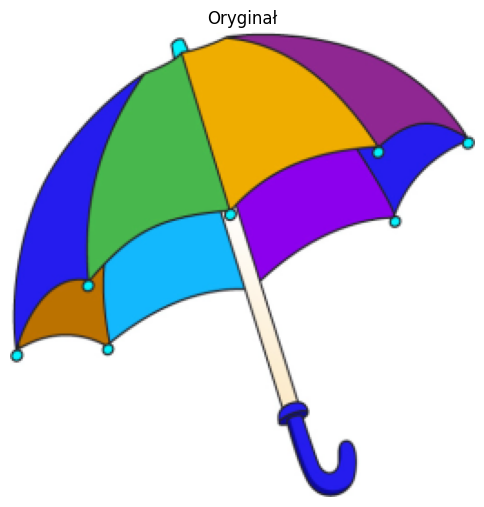

In [8]:
umbrella = cv2.imread("umbrella.png", cv2.COLOR_BGR2RGB)

images = {
    "Oryginał": umbrella
}

plots(**images)

2. W pierwszym etapie należy dokonać konwersji do przestrzeni barw HSV.
   Następnie wybrać tylko składową H (tj. barwę).
   Można ją kontrolnie wyświetlić.

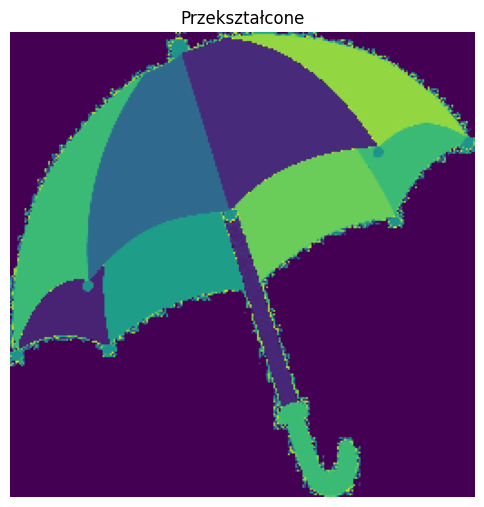

In [9]:
umbrella = cv2.cvtColor(umbrella, cv2.COLOR_RGB2HSV)[:, :, 0]

images = {
    "Przekształcone": umbrella
}

plots(**images)


3. Procedurę podziału wygodnie jest zrealizować w formie rekurencji.
   Utwórz funkcję np. `split`, która jako argumenty przyjmować będzie obraz oraz cztery współrzędne analizowanego podobszaru.
   W pierwszym kroku należy wyciąć odpowiedni fragment oraz obliczyć dla niego średnią i odchylenie standardowe (`np.mean` oraz `np.std`).


4. Następnie sprawdzamy czy odchylenie jest mniejsze niż zadany przez nas próg (np. 0.05) oraz czy nie osiągnęliśmy limitu podziału (np. bok kwadratu 8 pikseli).
  Oba potrzebne progi możemy zrealizować za pomocą zmiennych globalnych dostępnych w Python (po prostu zadeklarowanych przed funkcją).
  Potrzeby rozmiar kwadratu obliczamy na podstawie współrzędnych (przekazanych do funkcji jako argumenty)

   Uwaga. Użycie zmiennych globalnych jest złą praktyką programistyczną i zachęcamy do ''opakowania'' obliczeń w klasę - nie jest to jednak obowiązkowe.



5. Jeśli podobszar nie jest jednorodny (tj. duże odchylenie standardowe) i nie osiągnęliśmy minimalnego rozmiaru podobszaru to dokonujemy podziału na cztery części.
      Wyznaczamy rozmiar aktualnego podobszaru (na podstawie jego współrzędnych).
      Z ich wykorzystaniem otrzymujemy cztery identyczne podobszary ($I1,I2,I3,I4$).

      Następnie dla każdego z nich wywołujemy funkcję `split` - rekurencja.
      Najtrudniejsze jest odpowiednie podanie współrzędnych.
      Mają to być **rzeczywiste** współrzędne podobszaru we współrzędnych globalnych (obrazu w pełnej rozdzielczości).
      Podpowiedź. Trzeba ''odpowiednio'' wykorzystać współrzędne podobszaru przed podziałem (tj. argumenty funkcji) oraz rozmiar podobszaru.
      Należy zwrócić uwagę na to, aby nie wystąpił błąd przesunięcia o 1 tj. współrzędna była większa/mniejsza o 1 od rzeczywistej.
      W razie wątpliwości warto sobie te parametry wypisać na konsolę lub użyć debugera.


6. Jeśli podobszar jest jednorodny lub nie możemy już dalej prowadzić podziału to:
   - zapisujemy indeks danego podobszaru: ` seg_res[y1:y2, x1:x2] = index`, gdzie: `seg_res` to globalna macierz o rozmiarze takim jak obraz wejściowy (typ *int16*), `y1,y2,x1,x2` to współrzędne podobszaru. W macierzy `seg_res` zapisywane będą obszary jednorodne.
  Zmienna `index` jest globalnym licznikiem podobszarów.
  Powinna zostać zainicjowana wartością 1 przed pierwszym wywołaniem funkcji `split`.
  Następnie, każdorazowo po przypisaniu należy ją inkrementować.
  Uwaga. Aby możliwa była modyfikacja zmiennej globalnej, należy wewnątrz funkcji dodać np. linijkę: `global seg_res`

  - zapisujemy średnią  podobszaru.
    Wykorzystujemy macierz globalną `MRes` oraz kod podobny do opisanego powyżej.
    Wartości te wykorzystamy przy etapie scalania.

  Uwaga. Podany sposób zapisu wyników podziału jest dość nieefektywny.
  Następuje powielenie tej samej informacji.
  Lepszym pomysłem byłoby wykorzystanie podejścia opartego o grafy, jednak jest ono trudniejsze do ''szybkiej'' implementacji.


In [13]:
def first_step(I: np.ndarray):
    img = I.copy()
    seg_res = np.zeros(img.shape, dtype=np.int16)
    MRes = np.zeros(img.shape)
    index = 1

    def split(img: np.ndarray, cords):
        nonlocal index

        x1, x2, y1, y2 = cords

        img_part = img[y1 : y2, x1 : x2].copy()
        mean = np.mean(img_part)
        std = np.std(img_part)

        THRESHOLD = 0.05
        BORDER_LIMIT = 8

        if std < THRESHOLD or (img_part.shape[0] <= BORDER_LIMIT and img_part.shape[1] <= BORDER_LIMIT):
            seg_res[y1:y2, x1:x2] = index
            MRes[y1:y2, x1:x2] = mean
            index += 1

        else:
            x_m = (x1 + x2) // 2
            y_m = (y1 + y2) // 2
            split(img, (x1, x_m, y1, y_m))
            split(img, (x_m, x2, y1, y_m))
            split(img, (x1, x_m, y_m, y2))
            split(img, (x_m, x2, y_m, y2))

    split(I, (0, I.shape[0], 0, I.shape[1]))

    return seg_res, MRes, index



7. Proszę wyświetlić macierze `seg_res` in `m_res`. Pierwsza powinna pokazywać podział na obszary - mniejsze lub większe kwadraty. Druga zasadniczo powinna wyglądać podobnie jak składowa H, tylko bardziej ''rozmazany''.

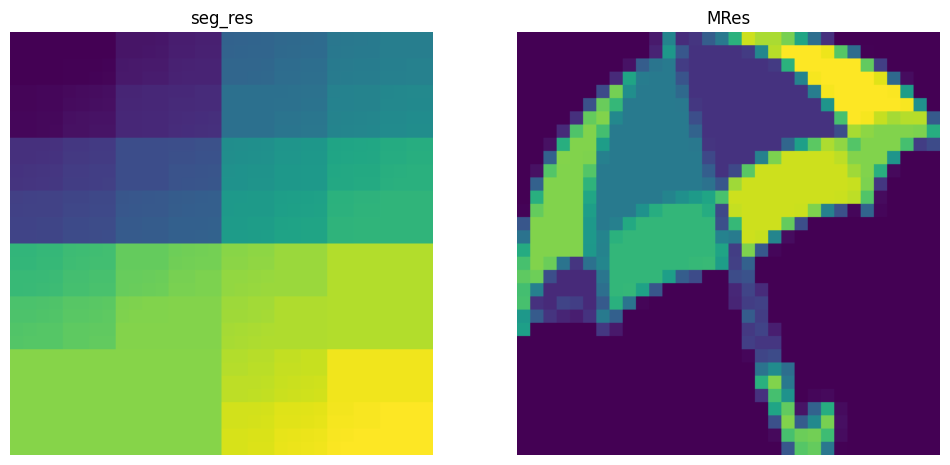

In [14]:
seg_res, MRes, index = first_step(umbrella)

images = {
    "seg_res": seg_res,
    "MRes": MRes
}

plots(**images)

## Drugi Etap

1. Drugi etap to łączenie.
   Idea jest nieco zbliżona do segmentacji przez rozrost.
   Wybieramy dany podobszar i analizujemy sąsiednie podobszary
   Jeśli są one podobne to dołączamy je do aktualnie rozpatrywanego.
   Za kryterium podobieństwa przyjmujemy niewielką różnicę w uśrednionym odcieniu barwy (składowa H).

2. Procedurę realizujemy wewnątrz pętli `while`.
   Warunkiem jej stopu jest przekroczenie przez licznik (np. `i`) wartości `index`, co oznacza, że przeanalizowane zostały wszystkie znalezione w pierwszym etapie podobszary.

3. W pierwszym kroku ''wycinamy'' maskę pikseli o rozpatrywanym indeksie tj. `ib = seg_res == i`.
   Dokonujemy też konwersji na typ *uint8*.
   Następnie sprawdzamy, czy maska zawiera elementy niezerowe tj. czy nie jest ''pusta'' - `np.any`.
   Taki przypadek może zajść jeśli pewien podobszar został dołączony do innego i zmienione zostały jego indeksy.
   Dla ''pustej'' maski inkrementujemy licznik `i` i przechodzimy do następnej iteracji - `continue`.

4. Dla rozpatrywanego podobszaru znajdujemy współrzędną lewego górnego rogu.
   Można to zrobić z wykorzystaniem składni: `(y, x) = np.nonzero(ib)` oraz  `first = (y[0], x[0])` - znajdywanie współrzędnych pierwszego niezerowego elementu.

5. Następnie należy znaleźć sąsiadów rozpatrywanego obszaru.
   Można wykorzystać dylatację maski ``ib`` z elementem strukturalnym w postaci kwadratu o rozmiarze $3 \times 3$ - `dil = cv2.dilate(ib, cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)))`
      Następnie od maski po dylatacji odejmujemy maskę oryginalną.
      Otrzymujemy ''ramkę'', którą wykorzystujemy do ''wycięcia'' (mnożenie punktowe) fragmentu z macierzy `seg_res`.
      Z tego fragmentu wybieramy elementy niezerowe (np. w ten sposób `mult_nz = mult[np.nonzero(mult)]`) i unikalne (tj. eliminacja duplikatów) - `mult_uniq = np.unique(mult_nz)`.

6. Mając wektor z indeksami sąsiadów realizujemy pętlę w której dla każdego sąsiada:
    - wycinamy opowiadającą mu maską i znajdujemy jej lewy górny róg - w sposób analogiczny do opisanego powyżej,
	- sprawdzamy, czy moduł z różnicy pomiędzy średnimi odcieniami barwy w dwóch analizowanych podobszarach jest mniejszy od progu (np. $5/255$). Jeśli tak to łączymy obszary tj. sąsiadowi przypisujemy indeks rozpatrywanego  `seg_res[ibs] = i`, gdzie `ibs` - maska podobszaru sąsiedniego.
	Do poprawnego działania konieczna jest jeszcze flaga informująca czy nastąpiło połączenie.
	Jej wartość ustawiamy na 0 przed pętlą po sąsiednich podobszarach.
	Jeśli wystąpiło połączenie to wartość ustawiamy na jeden.

	Po pętli po sąsiadach sprawdzamy flagę.
	Jeśli ma ona wartość 0 tj. nie nastąpiło połączenie obszarów to licznik	`i` jest inkrementowany.

7. Uwaga. Obliczenia mogą chwilę trwać.
   Proszę wyświetlić macierz `seg_res`.
   Jeśli implementacja jest poprawna, to wynik segmentacji powinien być względnie dobry - wszystkie elementy parasolki wyodrębnione.


8. Na koniec zastosujemy jeszcze dwie proste metody filtracji wyników.
   Po pierwsze wyeliminujemy obszary o rozmiarze mniejszym niż zadany (np. 100 pikseli).
   W tym celu wyznaczamy wektor unikalnych indeksów: `unique = np.unique(seg_res)`.
   Następnie implementujemy pętlę `for` po tych indeksach.
   Wewnątrz wycinamy maskę dla rozpatrywanego indeksu i obliczamy jej pole (`sum`).
   Jeśli jest ono mniejsze niż próg to cały podobszar ''zerujemy'' - `seg_res[mask] = 0`, gdzie `mask` - maska podobszaru.

9. W drugim kroku przeprowadzamy przeindeksowanie indeksów na pierwsze N liczb całkowitych.
   Ponownie wyznaczamy unikalne indeksy.
   Następnie w pętli `for` wycinamy maskę o indeksie `U(ii)`, a do wyniku przypisujemy iterator pętli `seg_res[mask] = ii`.

10. Proszę poeksperymentować z różnymi parametrami.
    Wyniki proszę zaprezentować prowadzącemu.